## Figure 1
Architecture and Source-Station Map

In [3]:
import json
from obspy import read_events

globocat = read_events("globocat_1.2.0_20??.xml")

with open('station_dict.json', 'r') as f:
    station_dict = json.load(f)

KeyboardInterrupt: 

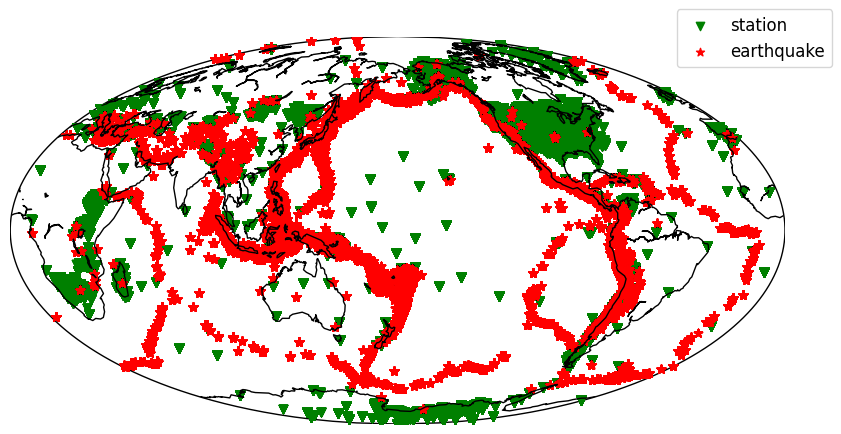

In [9]:
import glob
import numpy as np
import pandas as pd
from cmcrameri import cm
from obspy import UTCDateTime
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

df = pd.concat([pd.read_pickle(filename) for filename in glob.glob(f'result_table_centroid/updeANMO_shift5_catalog_*_plot.pkl')], ignore_index=True)

# st_lats = [ value['latitude'] for value in station_dict.values() ]
# st_lons = [ value['longitude']  for value in station_dict.values() ]
# ev_lats = [ ev.preferred_origin().latitude for ev in globocat ]
# ev_lons = [ ev.preferred_origin().longitude for ev in globocat ]

st_lats = df['station_lat']
st_lons = df['station_lon']
ev_lats = df['origin_lat']
ev_lons = df['origin_lon']

# phase ='p'
plt.rcParams["font.size"] = 12
# plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10,6))
map = Basemap(projection='moll',lon_0=-180,resolution='c',ax=ax)
# map.drawmapboundary(fill_color='white'

x, y = map(st_lons, st_lats)
ax.scatter(x, y, c='g', marker='v')
x, y = map(ev_lons, ev_lats)
ax.scatter(x, y, c='r', marker='*')

map.drawmapboundary()#fill_color='whitesmoke')
map.drawcoastlines()
ax.legend(['station', 'earthquake'], loc='lower left', bbox_to_anchor=(0.85, 0.9))
# plt.title(f'source-receiver distribution \n for {len(st_lons)} stations and {len(ev_lons)} events')

plt.show()
# plt.savefig('src-sta_geo.png', bbox_inches="tight")

In [12]:
print(f'source-receiver distribution \n for {len(df["station"].unique())} stations and {len(df["origin_time"].unique())} events')

source-receiver distribution 
 for 5042 stations and 5880 events


----

## Figure 2
QC Criteria Cruve and Prediction Histogram

----

## Figure 3
Anomaly Maps Grouped by Layers

----

## Figure 4
Slope Analysis Over Depth and Frequency

In [35]:
df.columns#['arrival_id']

Index(['network', 'station', 'phase', 'arrival_time', 'origin_time',
       'travel_time', 'anomaly', 'probability', 'gcarc', 'azimuth',
       'backazimuth', 'origin_lat', 'origin_lon', 'origin_dep', 'turning_lat',
       'turning_lon', 'station_lat', 'station_lon', 'arrival_id', 'event_id',
       'anomaly_rev', 'anomaly_isc', 'trace_id'],
      dtype='object')

In [40]:
[ arrival_id.rsplit("/",2)[0] for arrival_id in df['arrival_id'].values]

['smi:local/ndk/C201412080854A/origin#cmtorigin/TA_L61A_LH',
 'smi:local/ndk/C201412080854A/origin#cmtorigin/TA_L61A_LH',
 'smi:local/ndk/C201412080854A/origin#cmtorigin/US_ELK_LH',
 'smi:local/ndk/C201412080854A/origin#cmtorigin/US_ELK_LH',
 'smi:local/ndk/C201412080854A/origin#cmtorigin/TA_L60A_LH',
 'smi:local/ndk/C201412080854A/origin#cmtorigin/TA_L60A_LH',
 'smi:local/ndk/C201412080854A/origin#cmtorigin/TA_F59A_LH',
 'smi:local/ndk/C201412080854A/origin#cmtorigin/TA_F59A_LH',
 'smi:local/ndk/C201412080854A/origin#cmtorigin/TA_L04D_LH',
 'smi:local/ndk/C201412080854A/origin#cmtorigin/TA_L04D_LH',
 'smi:local/ndk/C201412080854A/origin#cmtorigin/TA_F58A_LH',
 'smi:local/ndk/C201412080854A/origin#cmtorigin/TA_F58A_LH',
 'smi:local/ndk/C201412080854A/origin#cmtorigin/US_EGAK_LH',
 'smi:local/ndk/C201412080854A/origin#cmtorigin/US_EGAK_LH',
 'smi:local/ndk/C201412080854A/origin#cmtorigin/TA_109C_LH',
 'smi:local/ndk/C201412080854A/origin#cmtorigin/TA_109C_LH',
 'smi:local/ndk/C201412080

In [41]:
from export_catalog import plot_depthslice, plot_ratio
p_thres = 0.7
s_thres = 0.5

get_p_table = lambda gcarc_range: plot_depthslice(phase = 'p',
                    value = 'anomaly',
                    gcarc_range = gcarc_range,
                    fidelity_func = lambda p: p-p_thres,
                    value_constraint = lambda x: abs(x)<20,
                    raw_filename = 'result_table_centroid/updeANMO_shift5_catalog_*_plot.pkl',
                    summary_ray=True,
                    demean=True,
                    plot=False,
                    include_id=True
                )
get_s_table = lambda gcarc_range: plot_depthslice(phase = 's',
                    value = 'anomaly',
                    gcarc_range = gcarc_range,
                    fidelity_func = lambda p: p-s_thres,
                    value_constraint = lambda x: abs(x)<30,
                    raw_filename = 'result_table_centroid/updeANMO_shift5_catalog_*_plot.pkl',
                    summary_ray=True,
                    demean=True,
                    plot=False,
                    include_id=True
                )

In [42]:
from sklearn.linear_model import TheilSenRegressor

def get_scatter(get_table1, get_table2, gcarc_range):
    table1 = get_table1(gcarc_range).rename(columns={'anomaly': 'anomaly1', 'probability': 'probability1'}) 
    table2 = get_table2(gcarc_range).rename(columns={'anomaly': 'anomaly2', 'probability': 'probability2'})
    table1['trace_id'] = [ "/".join(arrival_id.split("/")[:-2]) for arrival_id in table1['arrival_id'].values]
    table2['trace_id'] = [ "/".join(arrival_id.split("/")[:-2]) for arrival_id in table2['arrival_id'].values]
    columns_to_add = table2.columns.difference(table1.columns).append(pd.Index(['trace_id']))
    return table1.merge(table2[columns_to_add], how='inner', on='trace_id')

def plot_ratio2(ax, scatter_table, gcarc_range: set, xlim=[-20,20], ylim=[-20,20], demean=False, substract_coef=0, x_dep_y=False, slope_two_sections=False, x_label=None, y_label=None, title=None):
    # scatter_table = get_scatter(get_table1, get_table2)

    x = scatter_table[f'anomaly{1 if not x_dep_y else 2}'].values
    y = scatter_table[f'anomaly{2 if not x_dep_y else 1}'].values
    x_prob = scatter_table[f'probability{1 if not x_dep_y else 2}'].values
    y_prob = scatter_table[f'probability{2 if not x_dep_y else 1}'].values
    y -= substract_coef*x
    if demean:
        x -= np.mean(x)
        y -= np.mean(y)
        
    if not x_dep_y:
        ax.scatter(x, y, np.minimum(x_prob, y_prob))
    else:
        ax.scatter(y, x, np.minimum(x_prob, y_prob))

    if slope_two_sections:
        slope = [None, None]
        x_bound = [x<=0, x>=0]
    else:
        slope = [None]
        x_bound = [x != np.nan]
    
    for i in range(len(slope)):
        fit_range = np.array([min(x[x_bound[i]]), max(x[x_bound[i]])])
        theilsen = TheilSenRegressor(random_state=42).fit(x[x_bound[i]].reshape(-1,1), y[x_bound[i]])
        slope[i] = round(float(np.diff(theilsen.predict(fit_range.reshape(-1,1))) / np.diff(fit_range)), 4)
        if not x_dep_y:
            if i == 0: ax.plot(np.array([min(x), max(x)]), theilsen.predict(np.array([min(x), max(x)]).reshape(-1,1)), color="darkgray", lw=2)
            ax.plot(fit_range, theilsen.predict(fit_range.reshape(-1,1)), color="w" if plt.rcParams["figure.facecolor"] == 'black' else "k", lw=3)
            
        else:
            slope[i] = round(1/slope[i], 4)
            if i == 0: ax.plot(theilsen.predict(np.array([min(x), max(x)]).reshape(-1,1)), np.array([min(x), max(x)]), color="darkgray", lw=2)
            ax.plot(theilsen.predict(fit_range.reshape(-1,1)), fit_range, color="w" if plt.rcParams["figure.facecolor"] == 'black' else "k", lw=3)
            
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    # print(ax.get_ylim())
    if x_label is not False: ax.set_xlabel("$\delta t_P (sec)$" if x_label is None else x_label)
    if y_label is not False: ax.set_ylabel("$\delta t_S (sec)$" if y_label is None else y_label)
    # ax.set_title((f'P and S travel time residuals in {gcarc_range[0]}~{gcarc_range[1]} deg\n' if title is None else title) + f'{len(x)} pts, ratio = {tuple(slope) if len(slope)>1 else slope[0]}' )
    print((f'P and S travel time residuals in {gcarc_range[0]}~{gcarc_range[1]} deg\n' if title is None else title) + f'{len(x)} pts, ratio = {tuple(slope) if len(slope)>1 else slope[0]}' )
    if title: ax.set_title(title, loc='left')
    ax.set_aspect('equal')
    
    return scatter_table

In [44]:
list(range(30,105,5))

[30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

In [43]:
dist_incr = 5
for dist_lb in range(30,105,dist_incr):
    get_scatter(get_p_table, get_s_table, (dist_lb, dist_lb+dist_incr)).to_pickle(f'su2024grl-scatter/{dist_lb}-{dist_lb+dist_incr}.pkl')
# get_scatter(get_p_table, get_s_table, (30, 32))

Processing rays: 100%|██████████| 16619/16619 [00:13<00:00, 1203.20it/s]


1871 outliers are removed
14748 points fit the conditions


Processing rays: 100%|██████████| 23443/23443 [00:24<00:00, 952.33it/s] 


2732 outliers are removed
20711 points fit the conditions


,network,station,phase,arrival_time,origin_time,travel_time,anomaly1,probability1,gcarc,azimuth,...,turning_lon,station_lat,station_lon,arrival_id,event_id,anomaly_rev,anomaly_isc,trace_id,anomaly2,probability2
0,TA,R60A,P,2014-12-08T09:01:11.908111Z,2014-12-08T08:55:00.200000Z,371.71,-0.328764,0.89,30.6627,9.36,...,-79.955,38.268,-76.581,smi:local/ndk/C201412080854A/origin#cmtorigin/...,quakeml:jun.su/globocat/evct-2014-12-08T08:55:...,NaN,NaN,smi:local/ndk/C201412080854A/origin#cmtorigin/...,8.248448,0.64
1,TA,TUL1,P,2014-12-08T09:01:05.157587Z,2014-12-08T08:55:00.200000Z,364.96,-3.978764,0.94,30.3116,338.51,...,-88.549,35.910,-95.792,smi:local/ndk/C201412080854A/origin#cmtorigin/...,quakeml:jun.su/globocat/evct-2014-12-08T08:55:...,NaN,NaN,smi:local/ndk/C201412080854A/origin#cmtorigin/...,-4.541552,0.58
2,TA,R55A,P,2014-12-08T09:01:07.227251Z,2014-12-08T08:55:00.200000Z,367.03,-1.548764,0.94,30.2702,3.92,...,-81.520,38.283,-80.119,smi:local/ndk/C201412080854A/origin#cmtorigin/...,quakeml:jun.su/globocat/evct-2014-12-08T08:55:...,NaN,NaN,smi:local/ndk/C201412080854A/origin#cmtorigin/...,7.418448,0.81
3,TA,R54A,P,2014-12-08T09:01:05.493675Z,2014-12-08T08:55:00.200000Z,365.29,-2.048764,0.94,30.1301,2.57,...,-81.905,38.191,-80.990,smi:local/ndk/C201412080854A/origin#cmtorigin/...,quakeml:jun.su/globocat/evct-2014-12-08T08:55:...,NaN,NaN,smi:local/ndk/C201412080854A/origin#cmtorigin/...,5.368448,0.64
4,US,MNTX,P,2014-12-08T09:01:19.823631Z,2014-12-08T08:55:00.200000Z,379.62,-1.848764,0.98,31.7370,321.18,...,-93.133,31.698,-105.382,smi:local/ndk/C201412080854A/origin#cmtorigin/...,quakeml:jun.su/globocat/evct-2014-12-08T08:55:...,NaN,NaN,smi:local/ndk/C201412080854A/origin#cmtorigin/...,0.498448,0.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9099,US,VBMS,P,2010-01-21T08:09:33.679492Z,2010-01-21T08:03:24.200000Z,369.48,1.481236,0.75,30.2426,35.10,...,-101.293,32.219,-90.518,smi:local/ndk/C201001210803A/origin#cmtorigin/...,quakeml:jun.su/globocat/evct-2010-01-21T08:03:...,NaN,NaN,smi:local/ndk/C201001210803A/origin#cmtorigin/...,0.378448,0.67
9100,TA,T32A,P,2010-01-21T08:09:38.621360Z,2010-01-21T08:03:24.200000Z,374.42,2.561236,0.72,30.6807,18.29,...,-105.334,37.180,-98.925,smi:local/ndk/C201001210803A/origin#cmtorigin/...,quakeml:jun.su/globocat/evct-2010-01-21T08:03:...,NaN,NaN,smi:local/ndk/C201001210803A/origin#cmtorigin/...,-0.241552,0.89
9101,TA,R30A,P,2010-01-21T08:09:43.767046Z,2010-01-21T08:03:24.200000Z,379.57,2.101236,0.76,31.3179,15.57,...,-105.974,38.284,-100.277,smi:local/ndk/C201001210803A/origin#cmtorigin/...,quakeml:jun.su/globocat/evct-2010-01-21T08:03:...,NaN,NaN,smi:local/ndk/C201001210803A/origin#cmtorigin/...,-1.981552,0.95
9102,ZM,N100,P,2010-01-07T08:35:19.464027Z,2010-01-07T08:29:10.300000Z,369.16,1.381236,0.77,30.1597,189.88,...,151.957,-81.652,122.590,smi:local/ndk/C201001070829A/origin#cmtorigin/...,quakeml:jun.su/globocat/evct-2010-01-07T08:29:...,NaN,NaN,smi:local/ndk/C201001070829A/origin#cmtorigin/...,0.698448,0.90


In [9]:
from export_catalog import plot_depthslice
p_thres = 0.7
s_thres = 0.5
gcarc_range = (0, 180)

p_table = plot_depthslice(phase = 'p',
            value = 'anomaly_rev',
            gcarc_range = gcarc_range,
            fidelity_func = lambda p: p-p_thres,
            value_constraint = lambda x: abs(x)<20,
            raw_filename = 'updeANMO_shift5_catalog_*_plot.pkl',
            summary_ray=True,
            demean=True,
            plot=False
        )
s_table = plot_depthslice(phase = 's',
    value = 'anomaly_rev',
    gcarc_range = gcarc_range,
    fidelity_func = lambda p: p-s_thres,
    value_constraint = lambda x: abs(x)<30,
    raw_filename = 'updeANMO_shift5_catalog_*_plot.pkl',
    summary_ray=True,
    demean=True,
    plot=False
)

get_p_table_rev = lambda gcarc_range: p_table.drop('anomaly', axis='columns').rename(columns={'anomaly_rev': 'anomaly'})
get_p_table_isc = lambda gcarc_range: p_table.drop('anomaly', axis='columns').rename(columns={'anomaly_isc': 'anomaly'})
get_s_table_rev = lambda gcarc_range: s_table.drop('anomaly', axis='columns').rename(columns={'anomaly_rev': 'anomaly'})
get_s_table_isc = lambda gcarc_range: s_table.drop('anomaly', axis='columns').rename(columns={'anomaly_isc': 'anomaly'})

Processing rays: 100%|██████████| 111901/111901 [01:32<00:00, 1214.88it/s]


10701 outliers are removed
101200 points fit the conditions


Processing rays: 100%|██████████| 3287/3287 [00:01<00:00, 3047.65it/s]


137 outliers are removed
3150 points fit the conditions


Processing rays: 100%|██████████| 82967/82967 [01:35<00:00, 871.87it/s] 


9564 outliers are removed
73403 points fit the conditions


Processing rays: 100%|██████████| 120951/120951 [03:11<00:00, 632.23it/s] 


13595 outliers are removed
107356 points fit the conditions
a) $30^\circ \leq \Delta < 40^\circ$46990 pts, ratio = 2.7996


Processing rays: 100%|██████████| 82925/82925 [01:24<00:00, 984.21it/s] 


9561 outliers are removed
73364 points fit the conditions


Processing rays: 100%|██████████| 138468/138468 [04:14<00:00, 543.85it/s]


12719 outliers are removed
125749 points fit the conditions
b) $40^\circ \leq \Delta < 50^\circ$53440 pts, ratio = 2.9377


Processing rays: 100%|██████████| 103589/103589 [02:07<00:00, 812.91it/s] 


11498 outliers are removed
92091 points fit the conditions


Processing rays: 100%|██████████| 164894/164894 [05:58<00:00, 459.85it/s] 


14071 outliers are removed
150823 points fit the conditions
c) $50^\circ \leq \Delta < 60^\circ$70458 pts, ratio = 2.9403


Processing rays: 100%|██████████| 144268/144268 [04:20<00:00, 553.47it/s] 


17739 outliers are removed
126529 points fit the conditions


Processing rays: 100%|██████████| 191457/191457 [06:49<00:00, 467.26it/s]


16724 outliers are removed
174733 points fit the conditions
d) $60^\circ \leq \Delta < 70^\circ$96250 pts, ratio = 3.0048


Processing rays: 100%|██████████| 90068/90068 [02:47<00:00, 538.12it/s]


11611 outliers are removed
78457 points fit the conditions


Processing rays: 100%|██████████| 113681/113681 [04:03<00:00, 466.18it/s]


9853 outliers are removed
103828 points fit the conditions
e) $70^\circ \leq \Delta < 75^\circ$57890 pts, ratio = 2.9291


Processing rays: 100%|██████████| 114105/114105 [04:38<00:00, 409.50it/s]


14953 outliers are removed
99152 points fit the conditions


Processing rays: 100%|██████████| 139676/139676 [06:23<00:00, 364.53it/s]


13097 outliers are removed
126579 points fit the conditions
f) $75^\circ \leq \Delta < 80^\circ$69693 pts, ratio = 3.3523


Processing rays: 100%|██████████| 141698/141698 [09:29<00:00, 248.66it/s]


18696 outliers are removed
123002 points fit the conditions


Processing rays: 100%|██████████| 169889/169889 [11:25<00:00, 247.84it/s]


19891 outliers are removed
149998 points fit the conditions
g) $80^\circ \leq \Delta < 85^\circ$82240 pts, ratio = 3.7566


Processing rays: 100%|██████████| 137753/137753 [09:26<00:00, 243.00it/s]


17909 outliers are removed
119844 points fit the conditions


Processing rays: 100%|██████████| 140893/140893 [06:48<00:00, 344.50it/s]


17963 outliers are removed
122930 points fit the conditions
h) $85^\circ \leq \Delta < 90^\circ$64588 pts, ratio = 4.4863


Processing rays: 100%|██████████| 95434/95434 [02:55<00:00, 544.38it/s] 


12783 outliers are removed
82651 points fit the conditions


Processing rays: 100%|██████████| 87466/87466 [02:57<00:00, 491.83it/s]


8422 outliers are removed
79044 points fit the conditions
i) $90^\circ \leq \Delta < 95^\circ$38020 pts, ratio = 5.6818


Processing rays: 100%|██████████| 41992/41992 [00:37<00:00, 1112.85it/s]


5327 outliers are removed
36665 points fit the conditions


Processing rays: 100%|██████████| 35518/35518 [00:35<00:00, 1013.84it/s]


3605 outliers are removed
31913 points fit the conditions
j) $95^\circ \leq \Delta < 100^\circ$13803 pts, ratio = 5.9453
k) P wave101200 pts, ratio = (3.3212, 13.0039)
l) S wave3150 pts, ratio = (2.0794, 4.3573)


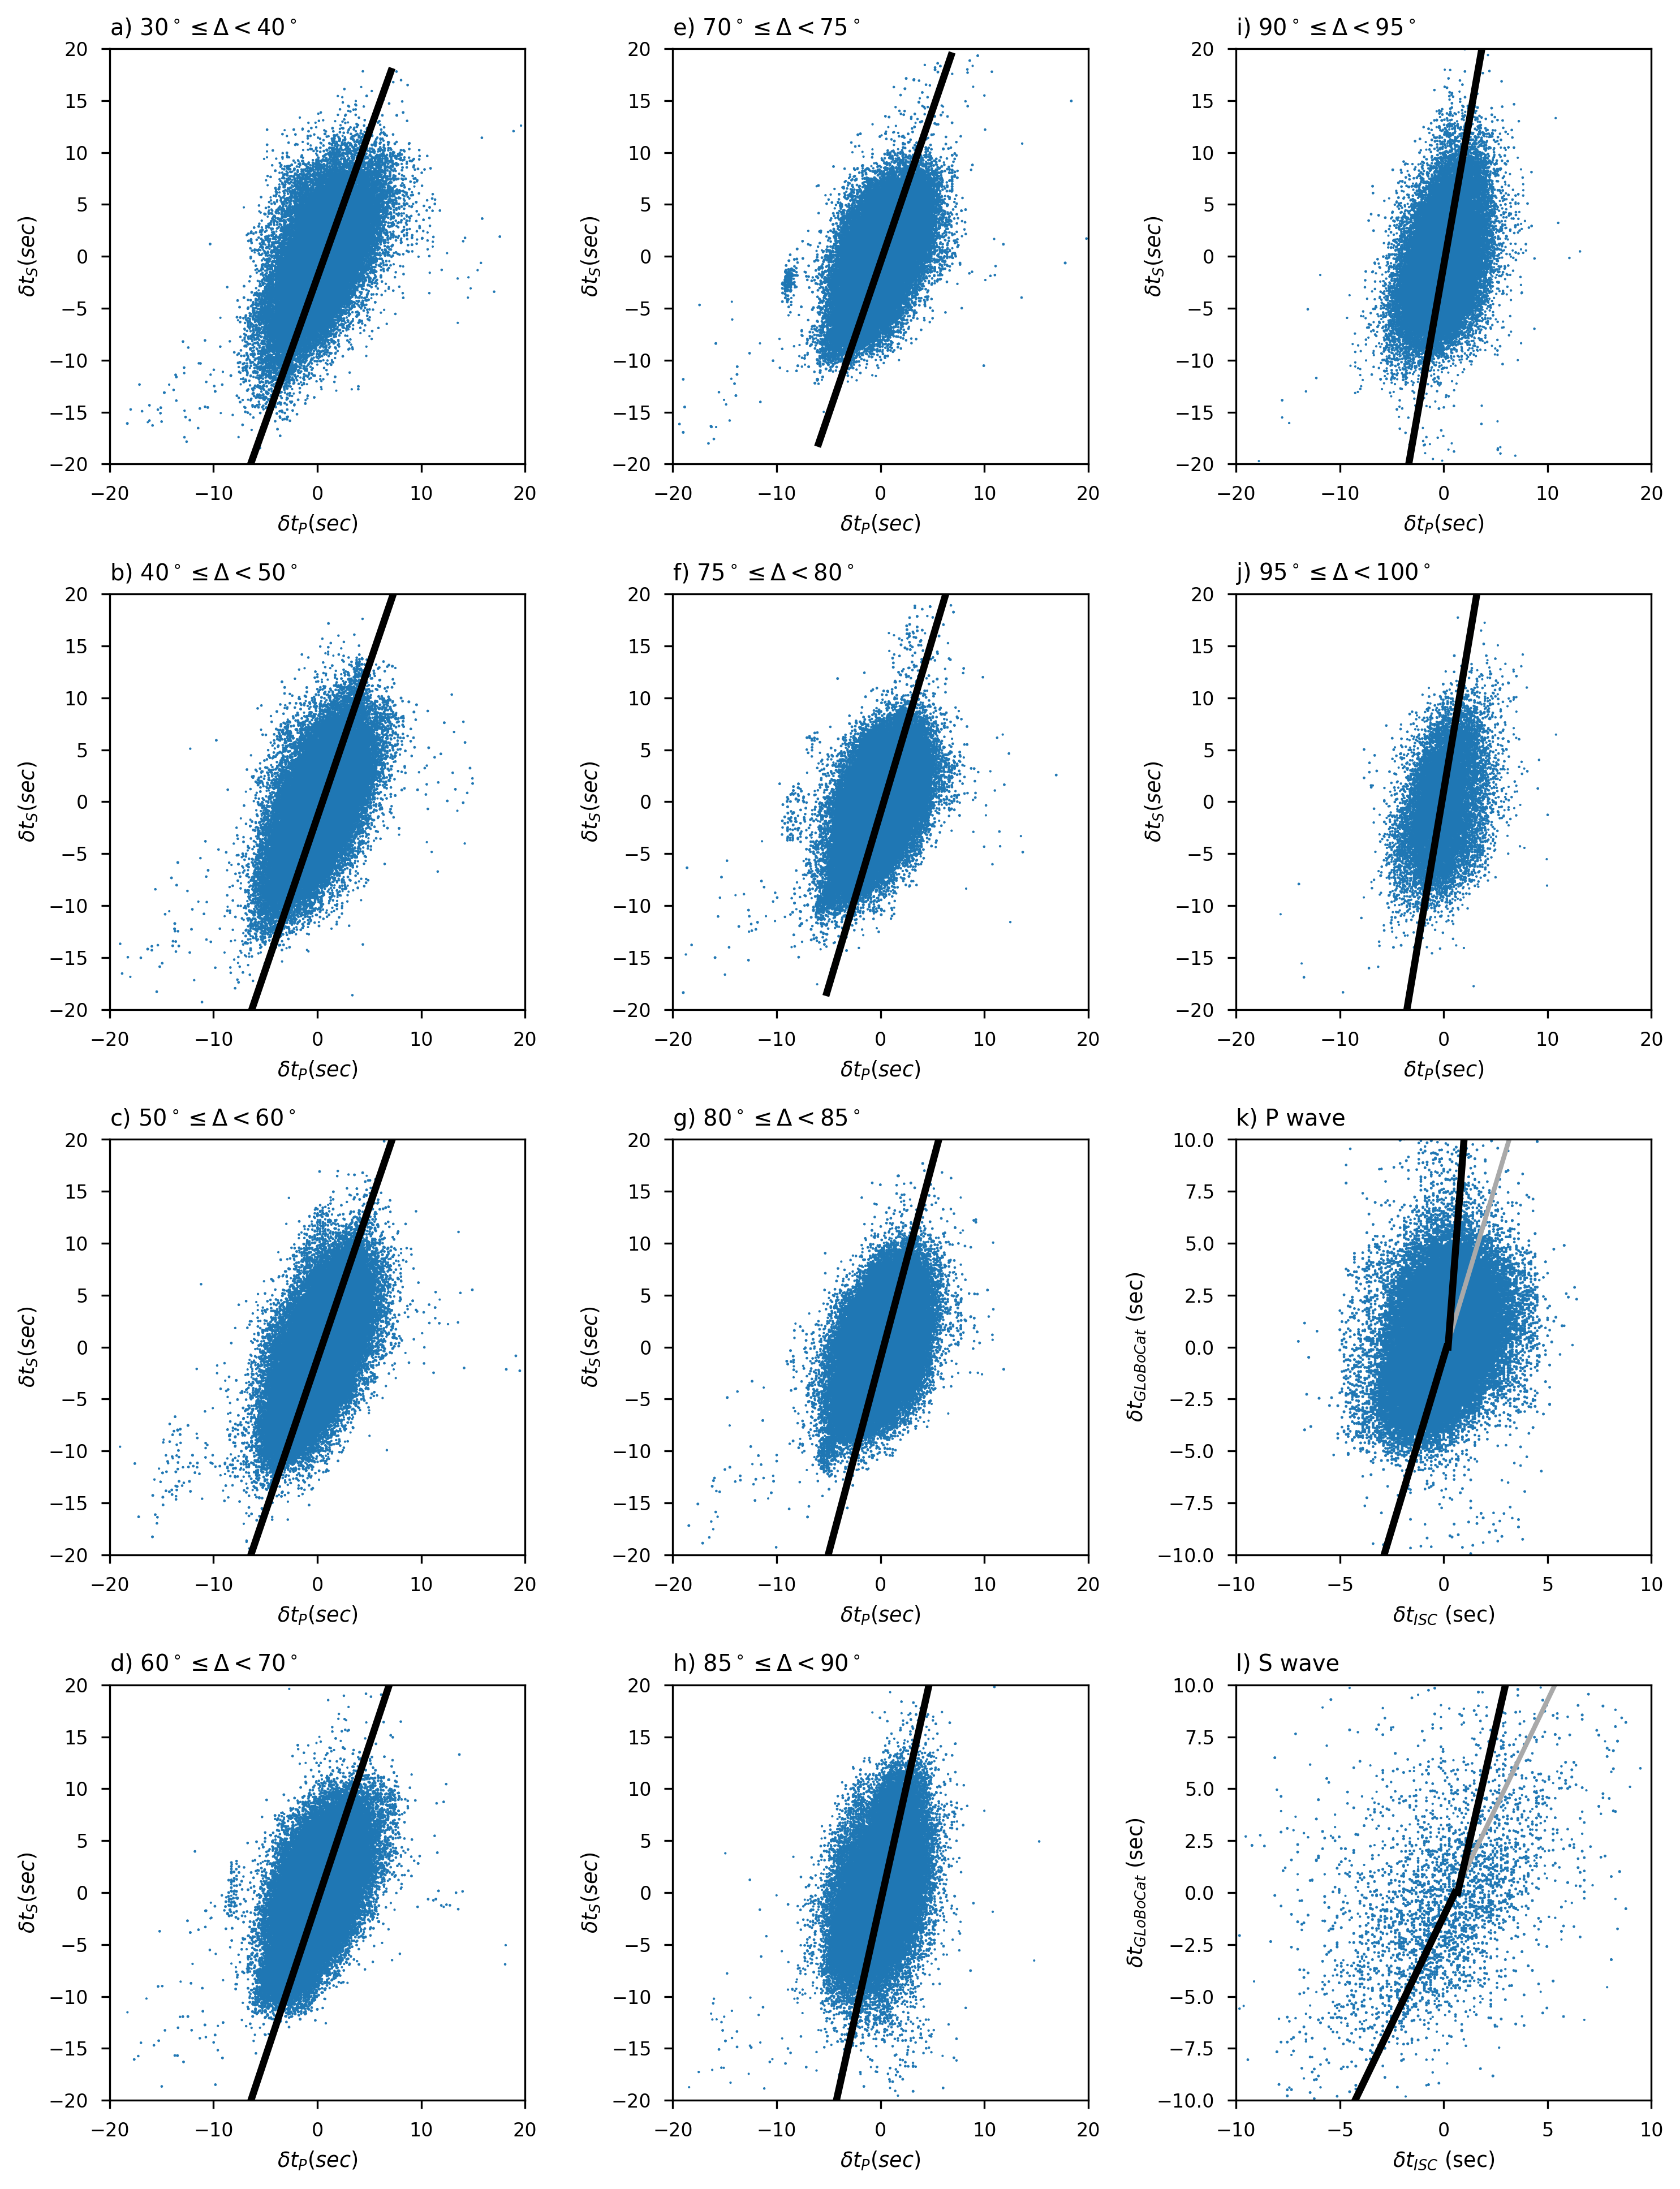

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt.cla(); plt.clf()

fig, axs = plt.subplots(4, 3, tight_layout=True, figsize=(10,13), dpi=300)
plt.style.use('seaborn-v0_8-paper')
# plt.rcParams["font.size"] = 12
plot_ratio2(axs[0,0], get_scatter(get_p_table, get_s_table, (30, 40)), (30, 40), x_dep_y=True, title="a) $30^\circ \leq \Delta < 40^\circ$")
plot_ratio2(axs[1,0], get_scatter(get_p_table, get_s_table, (40, 50)), (30, 40), x_dep_y=True, title="b) $40^\circ \leq \Delta < 50^\circ$")
plot_ratio2(axs[2,0], get_scatter(get_p_table, get_s_table, (50, 60)), (30, 40), x_dep_y=True, title="c) $50^\circ \leq \Delta < 60^\circ$")
plot_ratio2(axs[3,0], get_scatter(get_p_table, get_s_table, (60, 70)), (30, 40), x_dep_y=True, title="d) $60^\circ \leq \Delta < 70^\circ$")
plot_ratio2(axs[0,1], get_scatter(get_p_table, get_s_table, (70, 75)), (30, 40), x_dep_y=True, title="e) $70^\circ \leq \Delta < 75^\circ$")
plot_ratio2(axs[1,1], get_scatter(get_p_table, get_s_table, (75, 80)), (30, 40), x_dep_y=True, title="f) $75^\circ \leq \Delta < 80^\circ$")
plot_ratio2(axs[2,1], get_scatter(get_p_table, get_s_table, (80, 85)), (30, 40), x_dep_y=True, title="g) $80^\circ \leq \Delta < 85^\circ$")
plot_ratio2(axs[3,1], get_scatter(get_p_table, get_s_table, (85, 90)), (30, 40), x_dep_y=True, title="h) $85^\circ \leq \Delta < 90^\circ$")
plot_ratio2(axs[0,2], get_scatter(get_p_table, get_s_table, (90, 95)), (30, 40), x_dep_y=True, title="i) $90^\circ \leq \Delta < 95^\circ$")
plot_ratio2(axs[1,2], get_scatter(get_p_table, get_s_table, (95, 100)), (30, 40), x_dep_y=True, title="j) $95^\circ \leq \Delta < 100^\circ$")
plot_ratio2(axs[2,2], get_scatter(get_p_table_isc, get_p_table_rev, (0, 180)), (0, 180), [-10,10], [-10,10],
    demean=True, x_dep_y=True, slope_two_sections=True,
    x_label='$\delta t_{ISC}$ (sec)',
    y_label='$\delta t_{GLoBoCat}$ (sec)',
    title='k) P wave')
plot_ratio2(axs[3,2], get_s_table_isc, get_s_table_rev, (0, 180), [-10,10], [-10,10],
    demean=True, x_dep_y=True, slope_two_sections=True,
    x_label='$\delta t_{ISC}$ (sec)',
    y_label='$\delta t_{GLoBoCat}$ (sec)',
    title='l) S wave')

# plt.subplots_adjust(hspace=0.2)
# plt.savefig('qc_vpvs.70-110.png')
fig.show()